Importation des library

In [8]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os

Chargement des données

In [ ]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
time = '15m'
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2024-09-01', 
    interval=time
)

0it [00:00, ?it/s]

Mise en forme des données

In [10]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.index = df_raw.index.tz_convert('Europe/Paris')
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-07 12:00:00+01:00,3035.77,3038.02,3042.01,3035.24,2904.9257
2025-12-07 13:00:00+01:00,3049.12,3035.77,3050.96,3034.82,5827.0585
2025-12-07 14:00:00+01:00,3031.55,3049.12,3053.49,3026.98,8583.2673
2025-12-07 15:00:00+01:00,2942.65,3031.55,3035.22,2907.52,73593.9710
2025-12-07 16:00:00+01:00,2972.53,2942.65,2983.13,2940.00,38090.4963


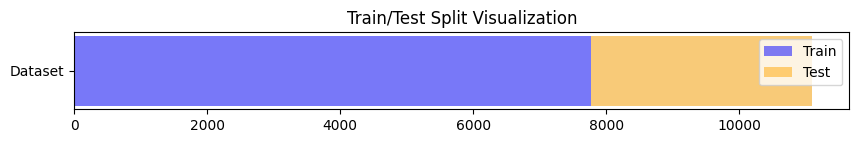

In [11]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [17]:
# Selection du train_set comme données d'entrainement
df = train_data.copy()
df.to_csv('backtest_test.csv', mode='a',header=not os.path.exists('backtest_test.csv'),index=False,)

**La stratégie**

Voici une stratégie simple de croisement de moyennes mobiles adaptée au 15 minutes :

Entrée Long : Quand la moyenne mobile 9 croise au-dessus de la moyenne mobile 21.
Sortie : Croisement inverse ou stop loss 2%.

In [13]:
# Calcul du RSI
#df['rsi'] = vbt.indicators.RSI.run(df['Close'], window=14).rsi

# Signaux long et short
#entries_long = df['rsi'] < 30
#exits_long = df['rsi'] > 50

#entries_short = df['rsi'] > 70
#exits_short = df['rsi'] < 50

**Backtest**

In [ ]:
rsi_window = 17
df['rsi'] = vbt.indicators.RSI.run(df['Close'], window=rsi_window).rsi

entries_long = df['rsi'] < 25
exits_long = df['rsi'] > 60

entries_short = df['rsi'] > 80
exits_short = df['rsi'] < 50

portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries_long,
    exits=exits_long,
    short_entries=entries_short,
    short_exits=exits_short,
    size_type='amount',
    size=35,
    init_cash=50,
    sl_stop=0.02,
    fees=0.001,
    slippage=0.001,
    freq=time
)

stats = portfolio.stats()
# Affichage des statistiques
print(portfolio.stats())
# ajout des statistique dans un csv (les ajouter a la suite et ne pas écraser les données existantes)
stats = portfolio.stats().to_frame().T
#stats.to_csv('backtest_1h.csv', mode='a',header=not os.path.exists('backtest_1h.csv'),index=False,)


# Tracer la valeur du portefeuille
portfolio.plot(width=1000, height=1000).show()

# Afficher les Trades
fig = portfolio.trades.plot()
fig.update_layout(width=1200, height=600)
fig.show()

Start                         2024-09-01 01:00:00+02:00
End                           2025-07-21 21:00:00+02:00
Period                                323 days 21:00:00
Start Value                                        50.0
End Value                                  -2106.384133
Total Return [%]                           -4312.768266
Benchmark Return [%]                          48.684645
Max Gross Exposure [%]                            100.0
Total Fees Paid                              504.544232
Max Drawdown [%]                             884.523762
Max Drawdown Duration                 310 days 09:00:00
Total Trades                                         11
Total Closed Trades                                  10
Total Open Trades                                     1
Open Trade PnL                              -746.401458
Win Rate [%]                                       70.0
Best Trade [%]                                  4.27801
Worst Trade [%]                               -3